<a href="https://colab.research.google.com/github/vibha-ctrl/TrainingASimpleNeuralNetworkWithCUDA/blob/main/TrainingASimpleNeuralNetworkWithCUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I've implemented a 2-layer neural network from scratch using custom CUDA kernels to classify handwritten digits from the MNIST dataset. Instead of using high-level libraries like PyTorch or TensorFlow, I wrote raw GPU kernels for matrix multiplication, ReLU activation, and softmax to understand how neural networks actually execute on hardware. Hope you will find this useful as you learn CUDA!

1) Setup

    My current computer doesn't have a GPU, hence I am using the T4 GPU available on Google Colab. To set this up, go to "Runtime" -> "Change Runtime Type" -> T4 GPU. Run the command below to ensure the GPU is present.


In [ ]:
!nvidia-smi

Mon Nov 17 21:41:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2) Dataset

    Load the MNIST dataset and preprocess the data. Specifically, split into a test and train dataset. Then, reshape each 28×28 image into a flat 784-dimensional vector (since the neural network's input layer expects a 1D array rather than a 2D grid). Normalize pixel values from [0, 255] to [0, 1] by dividing by 255.0, and convert to float32. To speed up training during development, use a subset of 5,000 training images and 1,000 test images. Finally, save these preprocessed arrays as binary files (train_images.bin, train_labels.bin, test_images.bin, test_labels.bin)


In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist

# Load and preprocess
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# Use subset for faster training
x_train = x_train[:5000]
y_train = y_train[:5000]
x_test = x_test[:1000]
y_test = y_test[:1000]

# Save as binary files
x_train.tofile('train_images.bin')
y_train.tofile('train_labels.bin')
x_test.tofile('test_images.bin')
y_test.tofile('test_labels.bin')

print(f"Training: {x_train.shape}, Test: {x_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training: (5000, 784), Test: (1000, 784)


3) Writing Matrix Multiplication Kernels

    Matrix multiplication is the core operation in neural networks. I implemented three custom CUDA kernels to handle different multiplication patterns required during training:

    - **Standard Matrix Multiply (`matmul_simple`):**
    Computes C = A × B where A is (M × K), B is (K × N), and C is (M × N). Each GPU thread computes one element of the output matrix by performing a dot product of the corresponding row from A and column from B. This kernel is used in the forward pass to compute layer activations: output = input × weights.

    - **Matrix Multiply with A Transposed (`matmul_At_B`):**
    Computes C = A^T × B where A is (K × M), B is (K × N), and C is (M × N). Instead of physically transposing matrix A in memory, the kernel reads A's elements in transposed order (accessing columns as rows). This is used during backpropagation to compute weight gradients: grad_weights = input^T × grad_output.

    - **Matrix Multiply with B Transposed (`matmul_A_Bt`):**
    Computes C = A × B^T where A is (M × K), B is (N × K), and C is (M × N). The kernel reads B's elements in transposed order by swapping the indexing pattern. This is used during backpropagation to propagate gradients backward through layers: grad_input = grad_output × weights^T. This allows us to compute how changes in the output affect the input.

      Here is a walk through of the matrix multiplication process focusing on the GPU blocks and threads:
      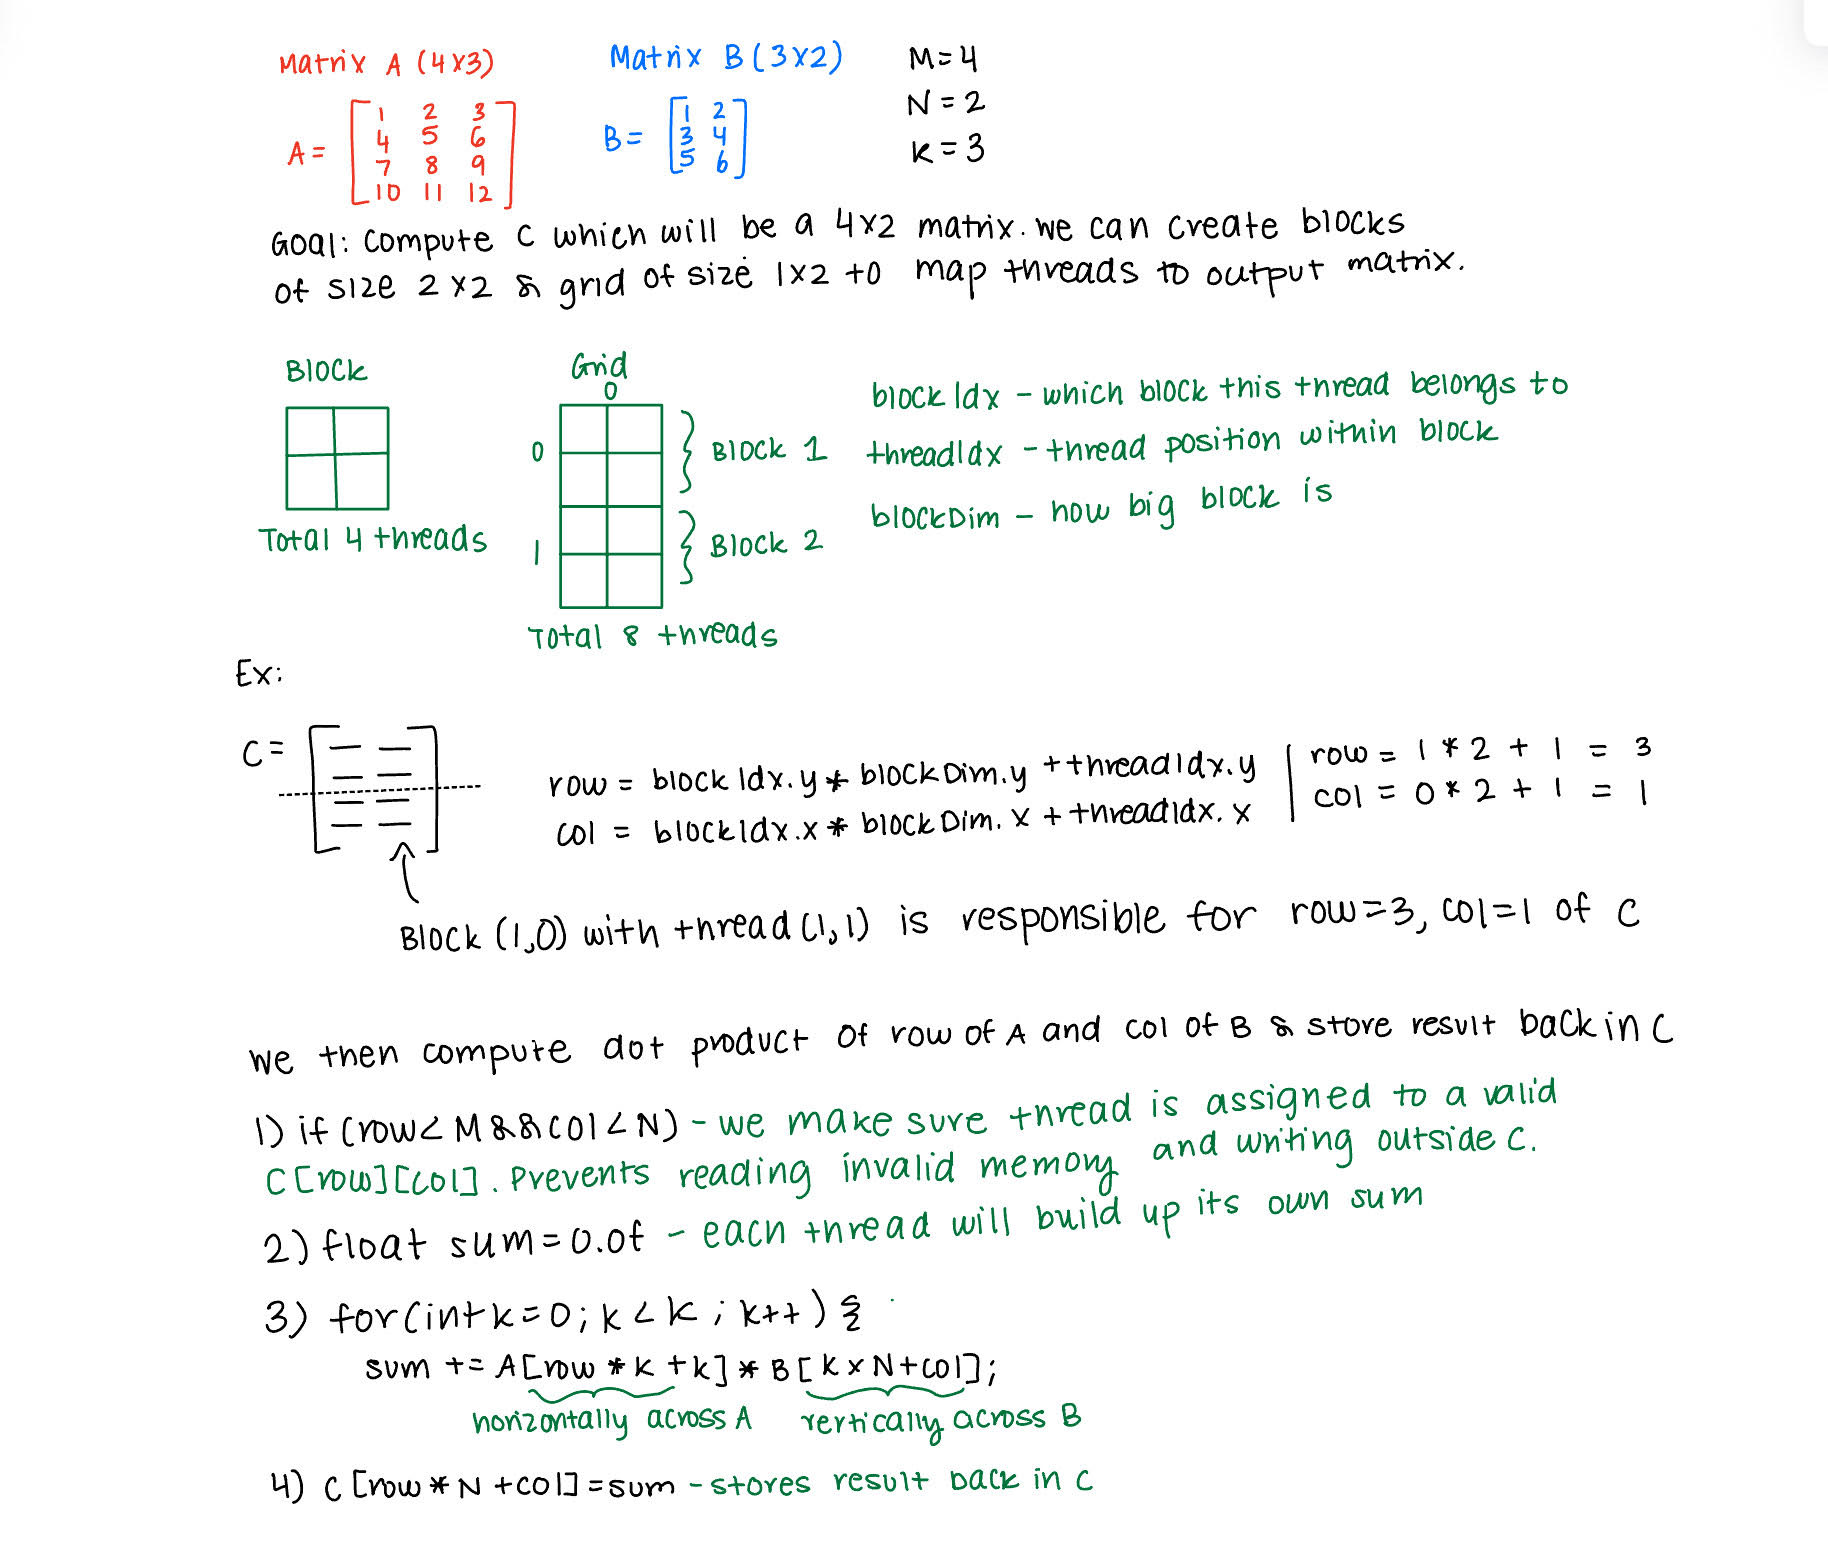

In [ ]:
%%writefile kernels_matmul.cu
#include <cuda_runtime.h>

__global__ void matmul_simple(float* A, float* B, float* C, int M, int K, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < M && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < K; k++) {
            sum += A[row * K + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

__global__ void matmul_At_B(float* A, float* B, float* C, int K, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < M && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < K; k++) {
            sum += A[k * M + row] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

__global__ void matmul_A_Bt(float* A, float* B, float* C, int M, int K, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < M && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < K; k++) {
            sum += A[row * K + k] * B[col * K + k];
        }
        C[row * N + col] = sum;
    }
}

Writing kernels_matmul.cu


4) Activation Function Kernals

    I implemented custom CUDA kernels for activation functions that introduce non-linearity into the neural network and enable learning of complex patterns.

    - **Add Bias and ReLU (`add_bias_relu`):**
    Combines two operations in a single kernel for efficiency. First adds bias terms to each neuron's output, then applies the ReLU (Rectified Linear Unit) activation function which sets all negative values to zero: f(x) = max(0, x). This kernel is used in hidden layers where non-linearity is essential for the network to learn complex decision boundaries. By fusing bias addition and ReLU into one kernel, we reduce memory bandwidth usage and improve performance.

    - **Add Bias Only (`add_bias`):**
    Adds bias terms to layer outputs without applying activation. Each neuron has an associated bias value that shifts its activation threshold. This kernel is used for the output layer before softmax, where we need the raw logits (pre-activation values) for the probability computation. The bias allows the network to fit data that doesn't pass through the origin.

    - **ReLU Backward (`relu_backward`):**
    Implements the gradient computation through the ReLU activation during backpropagation. The ReLU gradient is simple: it's 1 where the input was positive, and 0 where it was negative or zero. This kernel zeros out gradients for neurons that were inactive (output was 0) in the forward pass, ensuring that only active neurons contribute to learning.

    - **Softmax (`softmax`):**
    Converts raw output logits into a probability distribution over the 10 digit classes. For numerical stability, we subtract the maximum value before computing exponentials to prevent overflow. Each sample's outputs are normalized so they sum to 1.0, with each value representing the network's confidence that the input belongs to that particular digit class. The class with the highest probability becomes the final prediction.

      Below, I've walked though a few numerical examples so you can see what each of these kernals are doing

      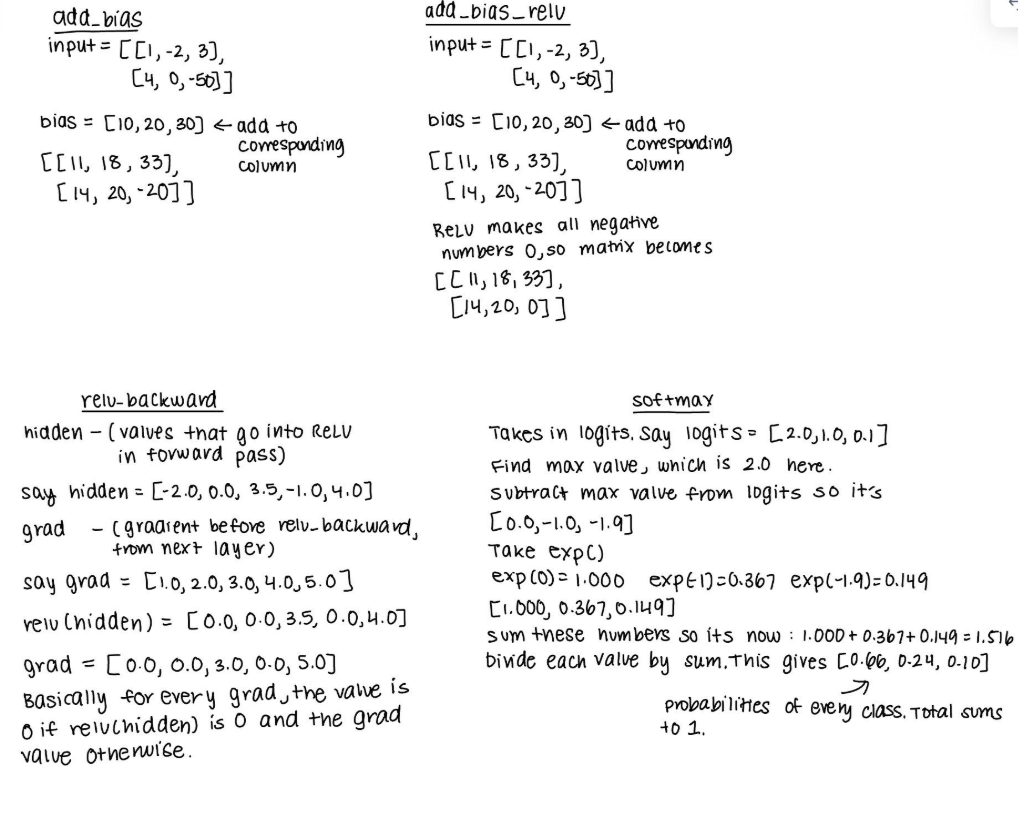

In [ ]:
%%writefile kernels_activation.cu
#include <cuda_runtime.h>
#include <math.h>

__global__ void add_bias_relu(float* input, float* bias, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < M && col < N) {
        int idx = row * N + col;
        input[idx] += bias[col];
        input[idx] = fmaxf(0.0f, input[idx]);
    }
}

__global__ void add_bias(float* input, float* bias, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < M && col < N) {
        input[row * N + col] += bias[col];
    }
}

__global__ void relu_backward(float* grad, float* hidden, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        if (hidden[idx] <= 0.0f) {
            grad[idx] = 0.0f;
        }
    }
}

__global__ void softmax(float* input, int batch, int classes) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < batch) {
        float max_val = input[row * classes];
        for (int i = 1; i < classes; i++) {
            max_val = fmaxf(max_val, input[row * classes + i]);
        }

        float sum = 0.0f;
        for (int i = 0; i < classes; i++) {
            input[row * classes + i] = expf(input[row * classes + i] - max_val);
            sum += input[row * classes + i];
        }

        for (int i = 0; i < classes; i++) {
            input[row * classes + i] /= sum;
        }
    }
}

Writing kernels_activation.cu


5) Backpropagation and Optimization Kernels

    We implement kernels for computing gradients during backpropagation and updating network weights through gradient descent.

    - **Softmax Backward (`softmax_backward`):**
    Computes the gradient of the cross-entropy loss with respect to the network's output logits. This kernel combines the derivatives of both the softmax activation and the cross-entropy loss function into a single efficient operation. For each sample in the batch, it creates a gradient vector where the predicted probability for each class is copied, then 1.0 is subtracted from the true class position. This difference represents how wrong the prediction was - if the network predicted 0.9 for the correct class, the gradient is -0.1 (needs slight increase), but if it predicted 0.1, the gradient is -0.9 (needs large increase). The gradient is then normalized by the batch size to ensure stable learning regardless of batch size.
    - **Reduce Sum Bias (`reduce_sum_bias`):**
      Accumulates gradients across all samples in a batch to compute the total gradient for each bias term. Since bias values are shared across all samples in a batch (each neuron has one bias applied to all inputs), we must sum up the gradients from each sample to determine how much each bias contributed to the total error. Each thread handles one bias term, looping through all batch samples and summing their contributions. This reduction operation is essential because while weights connect specific input-output pairs, biases affect entire columns of the output.
    - **SGD Update (`sgd_update`):**
      Implements stochastic gradient descent (SGD), the optimization algorithm that actually modifies the network's weights to reduce loss. Each thread handles one weight parameter, updating it by subtracting the learning rate multiplied by its gradient: w = w - lr × grad_w. The learning rate (0.5 in our case) controls the step size

      Below, I've walked though a few numerical examples so you can see what each of these kernals are doing:

      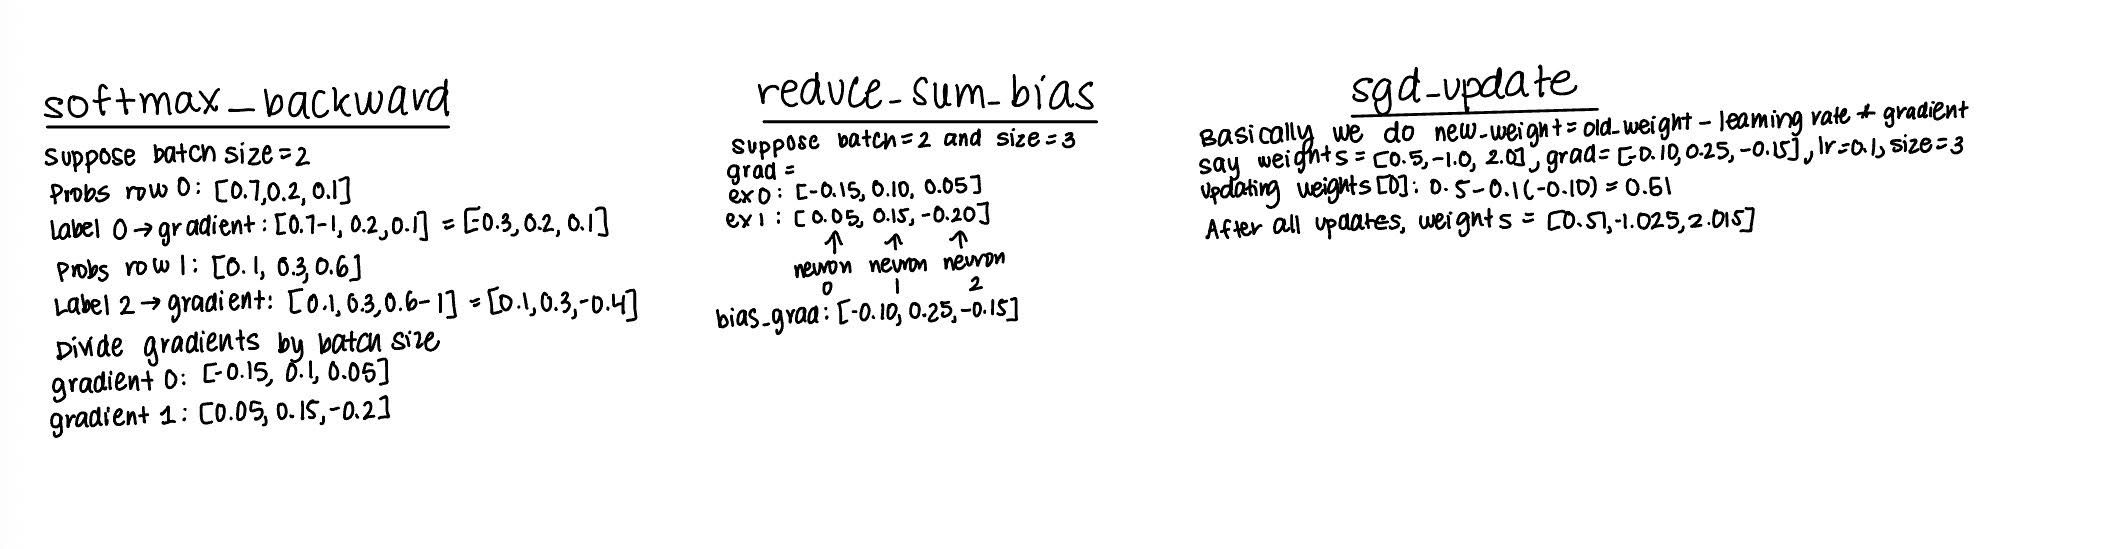



In [ ]:
%%writefile kernels_backprop.cu
#include <cuda_runtime.h>

__global__ void softmax_backward(float* probs, unsigned char* labels, float* grad, int batch, int classes) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < batch) {
        for (int i = 0; i < classes; i++) {
            grad[row * classes + i] = probs[row * classes + i];
            if (i == labels[row]) {
                grad[row * classes + i] -= 1.0f;
            }
            grad[row * classes + i] /= (float)batch;
        }
    }
}

__global__ void reduce_sum_bias(float* grad, float* bias_grad, int batch, int size) {
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (col < size) {
        float sum = 0.0f;
        for (int i = 0; i < batch; i++) {
            sum += grad[i * size + col];
        }
        bias_grad[col] = sum;
    }
}

__global__ void sgd_update(float* weights, float* grad, float lr, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        weights[idx] -= lr * grad[idx];
    }
}

Writing kernels_backprop.cu


6) Utility Functions

    These helper routines handle dataset loading, model parameter initialization, and saving trained weights. Although the compute-heavy parts of training run on the GPU, these steps are performed on the host
    
    - **Load Data (`load_data`):**
    Reads the images and labels from binary files. It allocates memory for all samples and loads pixel values as floats and labels as unsigned bytes (0–9). After loading, these arrays can be transferred to GPU memory for fast batched training.

    - **Initialize Weights (`init_weights`):**
    Allocates weight matrices and bias vectors for a two-layer fully connected network (Input → Hidden → Output). These initialized parameters are later copied to the GPU for forward and backward passes.

   - **Save Weights (`save_weights`):**
   Writes the trained model’s weight and bias arrays to binary files (weights_w1.bin, weights_w2.bin, bias_b1.bin, bias_b2.bin). This provides a persistent checkpoint of the learned model parameters for inference or continued training.
  
    Each 28×28 image is flattened into a 784-element input vector, passed through a 128-unit hidden layer with ReLU activation, and finally mapped to 10 output logits representing class probabilities via softmax. The utility functions in this file allocate and initialize the corresponding weight matrices (784×128 and 128×10) + bias vectors.

In [ ]:
%%writefile utils.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define HIDDEN_SIZE 128
#define INPUT_SIZE 784
#define OUTPUT_SIZE 10

void load_data(float** images, unsigned char** labels, int n_samples,
               const char* img_file, const char* label_file) {
    FILE* f_images = fopen(img_file, "rb");
    FILE* f_labels = fopen(label_file, "rb");

    if (!f_images || !f_labels) {
        printf("Error opening files: %s, %s\n", img_file, label_file);
        exit(1);
    }

    *images = (float*)malloc(n_samples * INPUT_SIZE * sizeof(float));
    *labels = (unsigned char*)malloc(n_samples * sizeof(unsigned char));

    fread(*images, sizeof(float), n_samples * INPUT_SIZE, f_images);
    fread(*labels, sizeof(unsigned char), n_samples, f_labels);

    fclose(f_images);
    fclose(f_labels);

    printf("Loaded %d samples from %s\n", n_samples, img_file);
}

void init_weights(float** w1, float** w2, float** b1, float** b2) {
    *w1 = (float*)malloc(INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    *w2 = (float*)malloc(HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float));
    *b1 = (float*)malloc(HIDDEN_SIZE * sizeof(float));
    *b2 = (float*)malloc(OUTPUT_SIZE * sizeof(float));

    float scale1 = sqrtf(2.0f / INPUT_SIZE);
    float scale2 = sqrtf(2.0f / HIDDEN_SIZE);

    for (int i = 0; i < INPUT_SIZE * HIDDEN_SIZE; i++) {
        (*w1)[i] = ((float)rand() / RAND_MAX - 0.5f) * 2.0f * scale1;
    }
    for (int i = 0; i < HIDDEN_SIZE * OUTPUT_SIZE; i++) {
        (*w2)[i] = ((float)rand() / RAND_MAX - 0.5f) * 2.0f * scale2;
    }
    for (int i = 0; i < HIDDEN_SIZE; i++) (*b1)[i] = 0.0f;
    for (int i = 0; i < OUTPUT_SIZE; i++) (*b2)[i] = 0.0f;
}

void save_weights(float* h_w1, float* h_w2, float* h_b1, float* h_b2) {
    printf("\nSaving trained weights...\n");

    FILE* f_w1 = fopen("weights_w1.bin", "wb");
    FILE* f_w2 = fopen("weights_w2.bin", "wb");
    FILE* f_b1 = fopen("bias_b1.bin", "wb");
    FILE* f_b2 = fopen("bias_b2.bin", "wb");

    fwrite(h_w1, sizeof(float), INPUT_SIZE * HIDDEN_SIZE, f_w1);
    fwrite(h_w2, sizeof(float), HIDDEN_SIZE * OUTPUT_SIZE, f_w2);
    fwrite(h_b1, sizeof(float), HIDDEN_SIZE, f_b1);
    fwrite(h_b2, sizeof(float), OUTPUT_SIZE, f_b2);

    fclose(f_w1); fclose(f_w2); fclose(f_b1); fclose(f_b2);
    printf("Weights saved to disk!\n");
}

Writing utils.cu


7) Training + Evaluation Loop

    These routines coordinate the end-to-end learning process for the neural network. While individual math operations run on the GPU, this section manages data movement, kernel configuration, batch iteration, accuracy computation, and saving trained parameters. All orchestration is performed on the host.
    
    - **Dataset Loading (Train + Test):**
    Loads 5,000 training samples and 1,000 test samples from binary files into host memory. Each 28×28 image is flattened into a 784-element float vector and paired with a label (0–9). During training and evaluation, batches of these samples are copied to the GPU for computation.

    - **GPU Memory Allocation:**
    Allocates device-side buffers for inputs, labels, hidden activations, output logits, all gradients, and all model parameters (W1, b1, W2, b2). Keeping these arrays resident on the GPU enables efficient forward and backward passes without repeated host–device transfers.
  
    - **Kernel Configuration:**
    Defines the CUDA execution geometry using fixed 16×16 thread blocks and grid sizes computed from layer dimensions. Each CUDA kernel uses one thread per matrix element, allowing large matrix multiplications and activation functions to execute in parallel.

    - **Training Phase (Forward + Backward):**
    Iterates over the training dataset in batches of 64 samples.

      - Forward pass: Computes hidden activations (matmul + bias + ReLU) and output logits (matmul + bias + softmax).

      - Backward pass: Computes gradients for W1, W2, b1, and b2 using softmax derivative, matrix multiplications, and ReLU backward.

      - SGD updates: Applies weight and bias updates directly on the GPU. Only the training set influences parameter updates; the test set is never used for learning.
  
    - **Accuracy Evaluation:**
      After each epoch, the model performs an inference-only forward pass on the full training set (5,000 samples) and test set (1,000 samples). The predicted classes are compared to ground-truth labels to report classification accuracy and track learning progress.

    - **Saving Trained Weights:**
      Copies the final trained values of W1, W2, b1, and b2 from the GPU back to host memory and writes them to binary files. These saved parameters can be reused for inference or additional training.


In [ ]:
%%writefile main.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

#define HIDDEN_SIZE 128
#define INPUT_SIZE 784
#define OUTPUT_SIZE 10
#define BATCH_SIZE 64
#define LEARNING_RATE 0.5f
#define EPOCHS 20

// Declare external functions from utils.cu
extern void load_data(float** images, unsigned char** labels, int n_samples,
                      const char* img_file, const char* label_file);
extern void init_weights(float** w1, float** w2, float** b1, float** b2);
extern void save_weights(float* h_w1, float* h_w2, float* h_b1, float* h_b2);

// Declare kernel functions from kernels_matmul.cu
extern __global__ void matmul_simple(float* A, float* B, float* C, int M, int K, int N);
extern __global__ void matmul_At_B(float* A, float* B, float* C, int K, int M, int N);
extern __global__ void matmul_A_Bt(float* A, float* B, float* C, int M, int K, int N);

// Declare kernel functions from kernels_activation.cu
extern __global__ void add_bias_relu(float* input, float* bias, int M, int N);
extern __global__ void add_bias(float* input, float* bias, int M, int N);
extern __global__ void relu_backward(float* grad, float* hidden, int size);
extern __global__ void softmax(float* input, int batch, int classes);

// Declare kernel functions from kernels_backprop.cu
extern __global__ void softmax_backward(float* probs, unsigned char* labels, float* grad, int batch, int classes);
extern __global__ void reduce_sum_bias(float* grad, float* bias_grad, int batch, int size);
extern __global__ void sgd_update(float* weights, float* grad, float lr, int size);

// Helper function to evaluate accuracy
float evaluate_accuracy(float* h_images, unsigned char* h_labels,
                        float* d_input, float* d_w1, float* d_w2, float* d_b1, float* d_b2,
                        float* d_hidden, float* d_output,
                        int eval_samples, dim3 threads, dim3 blocks_hidden, dim3 blocks_output) {

    int correct = 0;
    // host buffer for probs for a full batch
    float* h_probs = (float*)malloc(BATCH_SIZE * OUTPUT_SIZE * sizeof(float));

    int num_full_batches = eval_samples / BATCH_SIZE;
    int remaining = eval_samples % BATCH_SIZE;
    int total_evaluated = 0;

    // ----- Full batches -----
    for (int batch_idx = 0; batch_idx < num_full_batches; batch_idx++) {
        int offset = batch_idx * BATCH_SIZE;
        int current_batch = BATCH_SIZE;

        cudaMemcpy(d_input, h_images + offset * INPUT_SIZE,
                   current_batch * INPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);

        // Forward pass only
        matmul_simple<<<blocks_hidden, threads>>>(d_input, d_w1, d_hidden,
                                                  current_batch, INPUT_SIZE, HIDDEN_SIZE);
        add_bias_relu<<<blocks_hidden, threads>>>(d_hidden, d_b1, current_batch, HIDDEN_SIZE);
        matmul_simple<<<blocks_output, threads>>>(d_hidden, d_w2, d_output,
                                                  current_batch, HIDDEN_SIZE, OUTPUT_SIZE);
        add_bias<<<blocks_output, threads>>>(d_output, d_b2, current_batch, OUTPUT_SIZE);
        softmax<<<(current_batch + 255) / 256, 256>>>(d_output, current_batch, OUTPUT_SIZE);

        cudaMemcpy(h_probs, d_output, current_batch * OUTPUT_SIZE * sizeof(float),
                   cudaMemcpyDeviceToHost);

        for (int j = 0; j < current_batch; j++) {
            int pred = 0;
            float max_prob = h_probs[j * OUTPUT_SIZE];
            for (int k = 1; k < OUTPUT_SIZE; k++) {
                if (h_probs[j * OUTPUT_SIZE + k] > max_prob) {
                    max_prob = h_probs[j * OUTPUT_SIZE + k];
                    pred = k;
                }
            }
            if (pred == h_labels[offset + j]) {
                correct++;
            }
        }

        total_evaluated += current_batch;
    }

    // ----- Last partial batch (if any) -----
    if (remaining > 0) {
        int offset = num_full_batches * BATCH_SIZE;
        int current_batch = remaining;

        cudaMemcpy(d_input, h_images + offset * INPUT_SIZE,
                   current_batch * INPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);

        matmul_simple<<<blocks_hidden, threads>>>(d_input, d_w1, d_hidden,
                                                  current_batch, INPUT_SIZE, HIDDEN_SIZE);
        add_bias_relu<<<blocks_hidden, threads>>>(d_hidden, d_b1, current_batch, HIDDEN_SIZE);
        matmul_simple<<<blocks_output, threads>>>(d_hidden, d_w2, d_output,
                                                  current_batch, HIDDEN_SIZE, OUTPUT_SIZE);
        add_bias<<<blocks_output, threads>>>(d_output, d_b2, current_batch, OUTPUT_SIZE);
        softmax<<<(current_batch + 255) / 256, 256>>>(d_output, current_batch, OUTPUT_SIZE);

        cudaMemcpy(h_probs, d_output, current_batch * OUTPUT_SIZE * sizeof(float),
                   cudaMemcpyDeviceToHost);

        for (int j = 0; j < current_batch; j++) {
            int pred = 0;
            float max_prob = h_probs[j * OUTPUT_SIZE];
            for (int k = 1; k < OUTPUT_SIZE; k++) {
                if (h_probs[j * OUTPUT_SIZE + k] > max_prob) {
                    max_prob = h_probs[j * OUTPUT_SIZE + k];
                    pred = k;
                }
            }
            if (pred == h_labels[offset + j]) {
                correct++;
            }
        }

        total_evaluated += current_batch;
    }

    free(h_probs);
    return 100.0f * correct / total_evaluated;
}

int main() {
    srand(42);

    // Load training data
    float* h_train_images;
    unsigned char* h_train_labels;
    load_data(&h_train_images, &h_train_labels, 5000,
              "train_images.bin", "train_labels.bin");

    // Load test data
    float* h_test_images;
    unsigned char* h_test_labels;
    load_data(&h_test_images, &h_test_labels, 1000,
              "test_images.bin", "test_labels.bin");

    // Initialize weights
    float *h_w1, *h_w2, *h_b1, *h_b2;
    init_weights(&h_w1, &h_w2, &h_b1, &h_b2);

    // Allocate GPU memory
    float *d_input, *d_w1, *d_w2, *d_b1, *d_b2;
    float *d_hidden, *d_output;
    float *d_grad_output, *d_grad_hidden;
    float *d_grad_w1, *d_grad_w2, *d_grad_b1, *d_grad_b2;
    unsigned char *d_labels;

    cudaMalloc(&d_input, BATCH_SIZE * INPUT_SIZE * sizeof(float));
    cudaMalloc(&d_w1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_w2, HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float));
    cudaMalloc(&d_b1, HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_b2, OUTPUT_SIZE * sizeof(float));
    cudaMalloc(&d_hidden, BATCH_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_output, BATCH_SIZE * OUTPUT_SIZE * sizeof(float));
    cudaMalloc(&d_labels, BATCH_SIZE * sizeof(unsigned char));
    cudaMalloc(&d_grad_output, BATCH_SIZE * OUTPUT_SIZE * sizeof(float));
    cudaMalloc(&d_grad_hidden, BATCH_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_grad_w1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_grad_w2, HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float));
    cudaMalloc(&d_grad_b1, HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_grad_b2, OUTPUT_SIZE * sizeof(float));

    // Copy weights to GPU
    cudaMemcpy(d_w1, h_w1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_w2, h_w2, HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b1, h_b1, HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b2, h_b2, OUTPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);

    int n_batches = 5000 / BATCH_SIZE;

    dim3 threads(16, 16);
    dim3 blocks_hidden((HIDDEN_SIZE + 15) / 16, (BATCH_SIZE + 15) / 16);
    dim3 blocks_output((OUTPUT_SIZE + 15) / 16, (BATCH_SIZE + 15) / 16);
    dim3 blocks_w1((HIDDEN_SIZE + 15) / 16, (INPUT_SIZE + 15) / 16);
    dim3 blocks_w2((OUTPUT_SIZE + 15) / 16, (HIDDEN_SIZE + 15) / 16);

    printf("\nTraining on GPU...\n");
    printf("Epoch | Train Acc | Test Acc\n");
    printf("------|-----------|----------\n");

    for (int epoch = 0; epoch < EPOCHS; epoch++) {

        // TRAINING PHASE
        for (int batch = 0; batch < n_batches; batch++) {
            int offset = batch * BATCH_SIZE;

            cudaMemcpy(d_input, h_train_images + offset * INPUT_SIZE,
                       BATCH_SIZE * INPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_labels, h_train_labels + offset,
                       BATCH_SIZE * sizeof(unsigned char), cudaMemcpyHostToDevice);

            // Forward pass
            matmul_simple<<<blocks_hidden, threads>>>(d_input, d_w1, d_hidden,
                                                      BATCH_SIZE, INPUT_SIZE, HIDDEN_SIZE);
            add_bias_relu<<<blocks_hidden, threads>>>(d_hidden, d_b1, BATCH_SIZE, HIDDEN_SIZE);
            matmul_simple<<<blocks_output, threads>>>(d_hidden, d_w2, d_output,
                                                      BATCH_SIZE, HIDDEN_SIZE, OUTPUT_SIZE);
            add_bias<<<blocks_output, threads>>>(d_output, d_b2, BATCH_SIZE, OUTPUT_SIZE);
            softmax<<<(BATCH_SIZE + 255) / 256, 256>>>(d_output, BATCH_SIZE, OUTPUT_SIZE);

            // Backward pass
            softmax_backward<<<(BATCH_SIZE + 255) / 256, 256>>>(d_output, d_labels, d_grad_output,
                                                                BATCH_SIZE, OUTPUT_SIZE);
            matmul_At_B<<<blocks_w2, threads>>>(d_hidden, d_grad_output, d_grad_w2,
                                                BATCH_SIZE, HIDDEN_SIZE, OUTPUT_SIZE);
            reduce_sum_bias<<<(OUTPUT_SIZE + 255) / 256, 256>>>(d_grad_output, d_grad_b2,
                                                                BATCH_SIZE, OUTPUT_SIZE);
            matmul_A_Bt<<<blocks_hidden, threads>>>(d_grad_output, d_w2, d_grad_hidden,
                                                    BATCH_SIZE, OUTPUT_SIZE, HIDDEN_SIZE);
            relu_backward<<<(BATCH_SIZE * HIDDEN_SIZE + 255) / 256, 256>>>(d_grad_hidden, d_hidden,
                                                                           BATCH_SIZE * HIDDEN_SIZE);
            matmul_At_B<<<blocks_w1, threads>>>(d_input, d_grad_hidden, d_grad_w1,
                                                BATCH_SIZE, INPUT_SIZE, HIDDEN_SIZE);
            reduce_sum_bias<<<(HIDDEN_SIZE + 255) / 256, 256>>>(d_grad_hidden, d_grad_b1,
                                                                BATCH_SIZE, HIDDEN_SIZE);

            // Update weights
            sgd_update<<<(INPUT_SIZE * HIDDEN_SIZE + 255) / 256, 256>>>(d_w1, d_grad_w1, LEARNING_RATE,
                                                                        INPUT_SIZE * HIDDEN_SIZE);
            sgd_update<<<(HIDDEN_SIZE * OUTPUT_SIZE + 255) / 256, 256>>>(d_w2, d_grad_w2, LEARNING_RATE,
                                                                         HIDDEN_SIZE * OUTPUT_SIZE);
            sgd_update<<<(HIDDEN_SIZE + 255) / 256, 256>>>(d_b1, d_grad_b1, LEARNING_RATE, HIDDEN_SIZE);
            sgd_update<<<(OUTPUT_SIZE + 255) / 256, 256>>>(d_b2, d_grad_b2, LEARNING_RATE, OUTPUT_SIZE);
        }

        cudaDeviceSynchronize();

        // EVALUATION PHASE - full train and full test
        float train_acc = evaluate_accuracy(h_train_images, h_train_labels,
                                            d_input, d_w1, d_w2, d_b1, d_b2,
                                            d_hidden, d_output,
                                            5000, threads, blocks_hidden, blocks_output);

        float test_acc = evaluate_accuracy(h_test_images, h_test_labels,
                                           d_input, d_w1, d_w2, d_b1, d_b2,
                                           d_hidden, d_output,
                                           1000, threads, blocks_hidden, blocks_output);

        printf("%5d | %8.2f%% | %8.2f%%\n", epoch + 1, train_acc, test_acc);
    }

    printf("\nTraining complete!\n");

    // Copy trained weights back to CPU
    cudaMemcpy(h_w1, d_w1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float), cudaMemcpyDeviceToHost);
    cudaMemcpy(h_w2, d_w2, HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float), cudaMemcpyDeviceToHost);
    cudaMemcpy(h_b1, d_b1, HIDDEN_SIZE * sizeof(float), cudaMemcpyDeviceToHost);
    cudaMemcpy(h_b2, d_b2, OUTPUT_SIZE * sizeof(float), cudaMemcpyDeviceToHost);

    save_weights(h_w1, h_w2, h_b1, h_b2);

    // Cleanup
    cudaFree(d_input); cudaFree(d_w1); cudaFree(d_w2); cudaFree(d_b1); cudaFree(d_b2);
    cudaFree(d_hidden); cudaFree(d_output);
    cudaFree(d_labels); cudaFree(d_grad_output); cudaFree(d_grad_hidden);
    cudaFree(d_grad_w1); cudaFree(d_grad_w2); cudaFree(d_grad_b1); cudaFree(d_grad_b2);
    free(h_train_images); free(h_train_labels);
    free(h_test_images); free(h_test_labels);
    free(h_w1); free(h_w2); free(h_b1); free(h_b2);

    return 0;
}

Writing main.cu


In [ ]:
!nvcc -arch=sm_75 kernels_matmul.cu kernels_activation.cu kernels_backprop.cu utils.cu main.cu -o train
!./train

Loaded 5000 samples from train_images.bin
Loaded 1000 samples from test_images.bin

Training on GPU...
Epoch | Train Acc | Test Acc
------|-----------|----------
    1 |    90.26% |    86.70%
    2 |    93.30% |    88.30%
    3 |    94.66% |    88.90%
    4 |    95.70% |    90.10%
    5 |    96.40% |    90.50%
    6 |    97.40% |    91.10%
    7 |    98.08% |    91.80%
    8 |    98.86% |    92.50%
    9 |    99.28% |    92.40%
   10 |    99.54% |    92.60%
   11 |    99.64% |    92.80%
   12 |    99.68% |    93.00%
   13 |    99.82% |    92.90%
   14 |    99.88% |    92.90%
   15 |    99.94% |    92.80%
   16 |    99.96% |    92.90%
   17 |    99.98% |    92.80%
   18 |    99.98% |    92.80%
   19 |   100.00% |    92.90%
   20 |   100.00% |    92.90%

Training complete!

Saving trained weights...
Weights saved to disk!


8) Inference

    This program runs the trained neural network in inference-only mode on the GPU. It loads saved weights and test images, performs forward passes on randomly chosen samples, and prints predictions with confidence.

    **Load Trained Weights**:
    Reads the learned parameters (W1, W2, b1, b2) from binary files (weights_w1.bin, weights_w2.bin, bias_b1.bin, bias_b2.bin) into host memory, then later copies them to the GPU for inference.

    **Load Test Data**:
    Loads 1,000 test images and labels from test_images.bin and test_labels.bin. Each image is a 784-element float vector (flattened 28×28), and each label is a digit from 0–9.

    **GPU Setup for Inference**:
    Allocates device buffers for a single input image, hidden activations, output logits, and all model parameters. Weights and biases are copied once from host to device, and a simple CUDA configuration (16×16 threads) is used for the hidden and output layers.

    **Single-Image Forward Pass & Prediction:**
    For each of 10 random test images, the program:

    1) Copies the chosen image to the GPU.

    2) Runs a forward pass using matmul_simple, add_bias_relu, add_bias, and softmax.
    
    3) Copies the output probabilities back to the host.
    
    4) Selects the most probable class as the prediction

In [ ]:
%%writefile inference.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <time.h>

#define HIDDEN_SIZE 128
#define INPUT_SIZE 784
#define OUTPUT_SIZE 10

// Declare kernel functions
extern __global__ void matmul_simple(float* A, float* B, float* C, int M, int K, int N);
extern __global__ void add_bias_relu(float* input, float* bias, int M, int N);
extern __global__ void add_bias(float* input, float* bias, int M, int N);
extern __global__ void softmax(float* input, int batch, int classes);

// Load saved weights
void load_weights(float** w1, float** w2, float** b1, float** b2) {
    *w1 = (float*)malloc(INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    *w2 = (float*)malloc(HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float));
    *b1 = (float*)malloc(HIDDEN_SIZE * sizeof(float));
    *b2 = (float*)malloc(OUTPUT_SIZE * sizeof(float));

    FILE* f_w1 = fopen("weights_w1.bin", "rb");
    FILE* f_w2 = fopen("weights_w2.bin", "rb");
    FILE* f_b1 = fopen("bias_b1.bin", "rb");
    FILE* f_b2 = fopen("bias_b2.bin", "rb");

    if (!f_w1 || !f_w2 || !f_b1 || !f_b2) {
        printf("Error: Could not load trained weights!\n");
        printf("Make sure you've run training first.\n");
        exit(1);
    }

    fread(*w1, sizeof(float), INPUT_SIZE * HIDDEN_SIZE, f_w1);
    fread(*w2, sizeof(float), HIDDEN_SIZE * OUTPUT_SIZE, f_w2);
    fread(*b1, sizeof(float), HIDDEN_SIZE, f_b1);
    fread(*b2, sizeof(float), OUTPUT_SIZE, f_b2);

    fclose(f_w1); fclose(f_w2); fclose(f_b1); fclose(f_b2);

    printf("Loaded trained weights from disk\n");
}

// Load test data
void load_test_data(float** images, unsigned char** labels, int n_samples) {
    FILE* f_images = fopen("test_images.bin", "rb");
    FILE* f_labels = fopen("test_labels.bin", "rb");

    if (!f_images || !f_labels) {
        printf("Error opening test files!\n");
        exit(1);
    }

    *images = (float*)malloc(n_samples * INPUT_SIZE * sizeof(float));
    *labels = (unsigned char*)malloc(n_samples * sizeof(unsigned char));

    fread(*images, sizeof(float), n_samples * INPUT_SIZE, f_images);
    fread(*labels, sizeof(unsigned char), n_samples, f_labels);

    fclose(f_images);
    fclose(f_labels);

    printf("Loaded %d test samples\n", n_samples);
}

int main() {
    srand(time(NULL));

    printf("\n========================================\n");
    printf("MNIST Digit Classification - Inference\n");
    printf("========================================\n\n");

    // Load test data
    float* h_test_images;
    unsigned char* h_test_labels;
    load_test_data(&h_test_images, &h_test_labels, 1000);

    // Load trained weights
    float *h_w1, *h_w2, *h_b1, *h_b2;
    load_weights(&h_w1, &h_w2, &h_b1, &h_b2);

    // Allocate GPU memory
    float *d_input, *d_w1, *d_w2, *d_b1, *d_b2;
    float *d_hidden, *d_output;

    cudaMalloc(&d_input, INPUT_SIZE * sizeof(float));
    cudaMalloc(&d_w1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_w2, HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float));
    cudaMalloc(&d_b1, HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_b2, OUTPUT_SIZE * sizeof(float));
    cudaMalloc(&d_hidden, HIDDEN_SIZE * sizeof(float));
    cudaMalloc(&d_output, OUTPUT_SIZE * sizeof(float));

    // Copy weights to GPU
    cudaMemcpy(d_w1, h_w1, INPUT_SIZE * HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_w2, h_w2, HIDDEN_SIZE * OUTPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b1, h_b1, HIDDEN_SIZE * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_b2, h_b2, OUTPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);

    dim3 threads(16, 16);
    dim3 blocks_hidden((HIDDEN_SIZE + 15) / 16, 1);
    dim3 blocks_output((OUTPUT_SIZE + 15) / 16, 1);

    float* h_probs = (float*)malloc(OUTPUT_SIZE * sizeof(float));

    printf("\n========================================\n");
    printf("Random Test Predictions\n");
    printf("========================================\n\n");

    // Show 10 random predictions
    int correct = 0;
    for (int i = 0; i < 10; i++) {
        // Pick random test image
        int idx = rand() % 1000;

        // Copy single image to GPU
        cudaMemcpy(d_input, h_test_images + idx * INPUT_SIZE,
                  INPUT_SIZE * sizeof(float), cudaMemcpyHostToDevice);

        // Forward pass
        matmul_simple<<<blocks_hidden, threads>>>(d_input, d_w1, d_hidden,
                                                  1, INPUT_SIZE, HIDDEN_SIZE);
        add_bias_relu<<<blocks_hidden, threads>>>(d_hidden, d_b1, 1, HIDDEN_SIZE);
        matmul_simple<<<blocks_output, threads>>>(d_hidden, d_w2, d_output,
                                                  1, HIDDEN_SIZE, OUTPUT_SIZE);
        add_bias<<<blocks_output, threads>>>(d_output, d_b2, 1, OUTPUT_SIZE);
        softmax<<<1, 256>>>(d_output, 1, OUTPUT_SIZE);

        // Get probabilities
        cudaMemcpy(h_probs, d_output, OUTPUT_SIZE * sizeof(float),
                  cudaMemcpyDeviceToHost);

        // Find prediction
        int pred = 0;
        float max_prob = h_probs[0];
        for (int k = 1; k < OUTPUT_SIZE; k++) {
            if (h_probs[k] > max_prob) {
                max_prob = h_probs[k];
                pred = k;
            }
        }

        int actual = h_test_labels[idx];

        // Print result
        printf("Image #%d:\n", idx);
        printf("  Actual:    %d\n", actual);
        printf("  Predicted: %d", pred);

        if (pred == actual) {
            printf(" ✓ CORRECT\n");
            correct++;
        } else {
            printf(" ✗ WRONG\n");
        }

        printf("  Confidence: %.2f%%\n", max_prob * 100);

        // Show probability distribution
        printf("  Probabilities: ");
        for (int k = 0; k < OUTPUT_SIZE; k++) {
            printf("%d:%.1f%% ", k, h_probs[k] * 100);
        }
        printf("\n\n");
    }

    printf("========================================\n");
    printf("Got %d out of 10 correct (%.1f%%)\n", correct, correct * 10.0f);
    printf("========================================\n\n");

    // Cleanup
    cudaFree(d_input); cudaFree(d_w1); cudaFree(d_w2); cudaFree(d_b1); cudaFree(d_b2);
    cudaFree(d_hidden); cudaFree(d_output);
    free(h_test_images); free(h_test_labels);
    free(h_w1); free(h_w2); free(h_b1); free(h_b2);
    free(h_probs);

    return 0;
}

Writing inference.cu


In [ ]:
!nvcc -arch=sm_75 kernels_matmul.cu kernels_activation.cu inference.cu -o inference
!./inference


MNIST Digit Classification - Inference

Loaded 1000 test samples
Loaded trained weights from disk

Random Test Predictions

Image #633:
  Actual:    2
  Predicted: 2 ✓ CORRECT
  Confidence: 100.00%
  Probabilities: 0:0.0% 1:0.0% 2:100.0% 3:0.0% 4:0.0% 5:0.0% 6:0.0% 7:0.0% 8:0.0% 9:0.0% 

Image #590:
  Actual:    3
  Predicted: 3 ✓ CORRECT
  Confidence: 100.00%
  Probabilities: 0:0.0% 1:0.0% 2:0.0% 3:100.0% 4:0.0% 5:0.0% 6:0.0% 7:0.0% 8:0.0% 9:0.0% 

Image #754:
  Actual:    1
  Predicted: 1 ✓ CORRECT
  Confidence: 99.99%
  Probabilities: 0:0.0% 1:100.0% 2:0.0% 3:0.0% 4:0.0% 5:0.0% 6:0.0% 7:0.0% 8:0.0% 9:0.0% 

Image #416:
  Actual:    1
  Predicted: 1 ✓ CORRECT
  Confidence: 100.00%
  Probabilities: 0:0.0% 1:100.0% 2:0.0% 3:0.0% 4:0.0% 5:0.0% 6:0.0% 7:0.0% 8:0.0% 9:0.0% 

Image #687:
  Actual:    3
  Predicted: 3 ✓ CORRECT
  Confidence: 98.83%
  Probabilities: 0:0.0% 1:0.0% 2:0.0% 3:98.8% 4:0.0% 5:0.0% 6:0.0% 7:0.0% 8:1.1% 9:0.0% 

Image #101:
  Actual:    0
  Predicted: 0 ✓ CORRECT
 